In [1]:
import torch_geometric.transforms as T
from torch_geometric.nn import global_max_pool, global_mean_pool, global_add_pool
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, ChebConv, SAGEConv, GATConv, DenseGCNConv
import matplotlib.pyplot as plt
import numpy as np
import utils
from torch_geometric.data import Data, Batch, DataLoader
from IPython.display import display, clear_output
import time

In [2]:
train_data = torch.load("data/MNISTSuperpixels_train_data.pt")
test_data = torch.load("data/MNISTSuperpixels_test_data.pt")

print(len(train_data))
print(len(test_data))

print(train_data[0])
print(test_data[0])

60000
10000
Data(edge_index=[2, 472], label=5, pos=[77, 2], x=[77, 3])
Data(edge_index=[2, 488], label=7, pos=[81, 2], x=[81, 3])


In [3]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

In [4]:
rotation_0 = T.RandomRotate(degrees=180, axis=0)
rotation_1 = T.RandomRotate(degrees=180, axis=1)
rotation_2 = T.RandomRotate(degrees=180, axis=2)

In [5]:
NUM_NODE_FEATURES = 3
NUM_CLASSES = 10

In [6]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GConv, self).__init__()
        self.conv1 = GCNConv(NUM_NODE_FEATURES, 32)
        self.conv2 = GCNConv(32, 64)
        self.conv3 = GCNConv(64, 64)  
        
        self.linear1 = nn.Linear(64, 32)
        self.linear2 = nn.Linear(32, NUM_CLASSES)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.15, training=self.training)
        x = self.conv3(x, edge_index)
        
        x = global_add_pool(x, data.batch)
#         x = global_mean_pool(x, data.batch)
#         x = global_max_pool(x, data.batch)
        
        x = self.linear1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.linear2(x)

        return F.log_softmax(x)

In [7]:
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        
        self.conv1 = GATConv(NUM_NODE_FEATURES, 32, heads=1)
        self.conv2 = GATConv(32, 64, heads=1)
        self.conv3 = GATConv(64, 64, heads=1)
        
        self.linear1 = nn.Linear(64, 32)
        self.linear2 = nn.Linear(32, NUM_CLASSES)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.15, training=self.training)
        x = self.conv3(x, edge_index)
        
        x = global_add_pool(x, data.batch)
        
        x = self.linear1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.linear2(x)
        
        return F.log_softmax(x)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [9]:
# model = GCN()
model = GAT()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [10]:
def evaluate():
    model.eval()
    acc = 0
    loss = 0
    for data in test_loader:
        
        data = data.to(device)
        out = model(data) 
        _, predicts = out.max(dim=1)
        target = torch.tensor(data.label).to(device)
        loss += F.nll_loss(out, target).item()
        correct = predicts.eq(target).sum().item()
        acc += correct
        
    acc =  acc * 100 / len(test_data)
    loss /= len(test_data)
    return acc, loss

In [11]:
acc, loss = evaluate()
print(acc)
print(loss)

C:\Users\Ukasz\Anaconda3\envs\gdl\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Ukasz\Anaconda3\envs\gdl\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


9.91
0.43620699672698976


In [12]:
train_loss_hist = []
test_loss_hist = []
acc_hist = []

for i in range(100):
    
    model.train()
    total_loss = 0
    
    for data in train_loader:     
        
        data = data.to(device)
        out = model(data)
        target = torch.tensor(data.label).to(device)
    
        optimizer.zero_grad()
        loss = F.nll_loss(out, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    train_loss = total_loss / len(train_data) 
    acc, test_loss = evaluate()
    
    train_loss_hist.append(train_loss)
    test_loss_hist.append(test_loss)
    acc_hist.append(acc)
    
    print(f"Ep: {i}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Acc: {acc:.2f}%")

C:\Users\Ukasz\Anaconda3\envs\gdl\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Ukasz\Anaconda3\envs\gdl\lib\site-packages\ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
C:\Users\Ukasz\Anaconda3\envs\gdl\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


Ep: 0, Train loss: 0.0648, Test loss: 0.0589, Acc: 32.75%
Ep: 1, Train loss: 0.0578, Test loss: 0.0532, Acc: 39.32%
Ep: 2, Train loss: 0.0512, Test loss: 0.0433, Acc: 52.17%
Ep: 3, Train loss: 0.0427, Test loss: 0.0368, Acc: 58.60%
Ep: 4, Train loss: 0.0380, Test loss: 0.0312, Acc: 66.14%
Ep: 5, Train loss: 0.0344, Test loss: 0.0279, Acc: 69.77%
Ep: 6, Train loss: 0.0315, Test loss: 0.0269, Acc: 69.45%
Ep: 7, Train loss: 0.0296, Test loss: 0.0225, Acc: 76.37%
Ep: 8, Train loss: 0.0282, Test loss: 0.0234, Acc: 74.68%
Ep: 9, Train loss: 0.0273, Test loss: 0.0198, Acc: 79.79%
Ep: 10, Train loss: 0.0262, Test loss: 0.0202, Acc: 78.44%
Ep: 11, Train loss: 0.0251, Test loss: 0.0197, Acc: 79.10%
Ep: 12, Train loss: 0.0242, Test loss: 0.0180, Acc: 81.83%
Ep: 13, Train loss: 0.0237, Test loss: 0.0166, Acc: 82.37%
Ep: 14, Train loss: 0.0231, Test loss: 0.0176, Acc: 80.78%
Ep: 15, Train loss: 0.0224, Test loss: 0.0170, Acc: 81.89%
Ep: 16, Train loss: 0.0216, Test loss: 0.0170, Acc: 81.82%
Ep: 17,

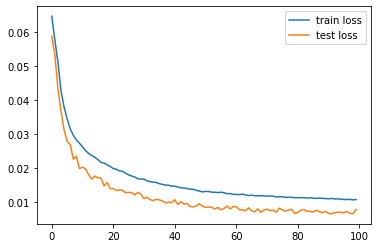

In [21]:
plt.plot(train_loss_hist, label='train loss')
plt.plot(test_loss_hist, label='test loss')
plt.legend()
plt.show()

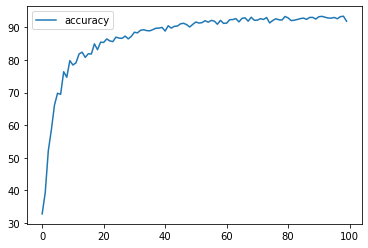

In [22]:
plt.plot(acc_hist, label='accuracy')
plt.legend()
plt.show()